<a href="https://colab.research.google.com/github/Lexie-D/Breast-Cancer-Classification/blob/main/Breast_Cancer_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Load the libraries

In [99]:
#Libraries
import pandas as pd
import numpy as np
import os
import random
import cv2

#Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    auc, ConfusionMatrixDisplay
)

# Viz
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns

#Image
import PIL.Image
from PIL import Image
from PIL import ImageOps
from IPython.display import display

#Tensor flow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau



import requests
import zipfile
import io
import glob

# 2. Load the Dataset

In [62]:
#Uploading the dataset
from google.colab import files
uploaded = files.upload()

Saving Dataset_BUSI_with_GT.zip to Dataset_BUSI_with_GT (1).zip


In [63]:
#Unzipping the file
zip_path = "Dataset_BUSI_with_GT.zip"
extract_to = "/content"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

#confirm location
extracted_path = os.path.join(extract_to, "Dataset_BUSI_with_GT")
print(extracted_path)

/content/Dataset_BUSI_with_GT


In [64]:
os.listdir(extracted_path)

['malignant', 'benign', 'normal']

# 3. Read and Explore the dataset

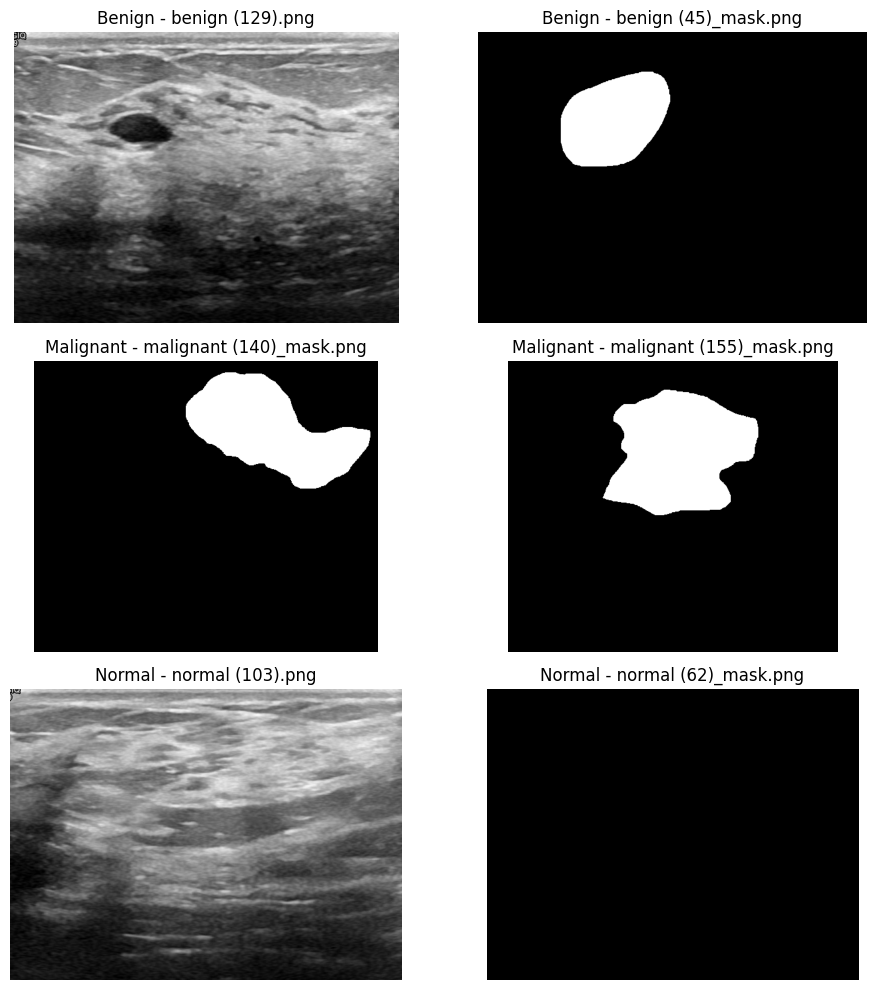

In [65]:
dataset_path = "/content/Dataset_BUSI_with_GT"
categories = ['benign', 'malignant', 'normal']

fig, axs = plt.subplots(len(categories), 2, figsize = (10, 10))

for i, category in enumerate(categories):
    category_path = os.path.join(dataset_path, category)
    image_files = [f for f in os.listdir(category_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    selected = random.sample(image_files, 2)

    for j in range(2):
        img = os.path.join(category_path, selected[j])
        img = Image.open(img).convert('L')  #images are all grey scale
        axs[i, j].imshow(img, cmap = 'grey')
        axs[i, j].axis('off')
        axs[i, j].set_title(f'{category.capitalize()} - {selected[j]}')

plt.tight_layout()
plt.show()

In [66]:
pd.DataFrame(
    os.listdir(extracted_path),
    columns = ['File Name']
)

,File Name
0,malignant
1,benign
2,normal


## All the paths in "extracted_path"

In [67]:
train_data = "/content/Dataset_BUSI_with_GT"

In [68]:
# Get all image file paths from subfolders
train_files = glob.glob(os.path.join(train_data, "*", "*.*"))

# Randomly shuffle the lists
random.shuffle(train_files)

# Extract labels from the directory names
labels = [os.path.basename(os.path.dirname(path)) for path in train_files]

# Create list of tuples (file path, label)
data = list(zip(train_files, labels))

# Convert to DataFrame
df = pd.DataFrame(data, columns=["Path", "Label"])

df

,Path,Label
0,/content/Dataset_BUSI_with_GT/malignant/malign...,malignant
1,/content/Dataset_BUSI_with_GT/benign/benign (3...,benign
2,/content/Dataset_BUSI_with_GT/benign/benign (4...,benign
3,/content/Dataset_BUSI_with_GT/normal/normal (2...,normal
4,/content/Dataset_BUSI_with_GT/normal/normal (4...,normal
...,...,...
1573,/content/Dataset_BUSI_with_GT/normal/normal (1...,normal
1574,/content/Dataset_BUSI_with_GT/benign/benign (6...,benign
1575,/content/Dataset_BUSI_with_GT/benign/benign (3...,benign
1576,/content/Dataset_BUSI_with_GT/malignant/malign...,malignant


# 4. Data Visualizations
# Distribution of Categories (3)

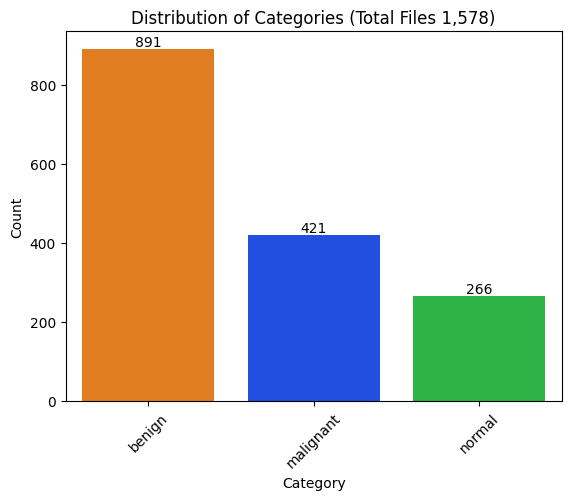

In [69]:
# Descending order
label_order = df['Label'].value_counts().sort_values(ascending = False).index

# Countplot
ax = sns.countplot(x = 'Label', data = df, order = label_order, hue = 'Label', palette = 'bright', legend = False)

# Display the counts per category above bars
for container in ax.containers:
  ax.bar_label(container)

# Plot
ax.set_title('Distribution of Categories (Total Files 1,578)')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## Collect Data Paths and Labels

In [70]:
# Path to "parent" dataset folder
dataset_path = "/content/Dataset_BUSI_with_GT"

# All image file paths
image_paths = glob.glob(os.path.join(dataset_path, "*", "*.png"))

# Shuffle the paths
np.random.shuffle(image_paths)

# All labels
labels = [os.path.basename(os.path.dirname(path)) for path in image_paths]

# Create DataFrame
df = pd.DataFrame({
    'Path': image_paths,
    'Label': labels
})

df.head()

,Path,Label
0,/content/Dataset_BUSI_with_GT/malignant/malign...,malignant
1,/content/Dataset_BUSI_with_GT/benign/benign (1...,benign
2,/content/Dataset_BUSI_with_GT/malignant/malign...,malignant
3,/content/Dataset_BUSI_with_GT/normal/normal (3...,normal
4,/content/Dataset_BUSI_with_GT/malignant/malign...,malignant


# 5. Data Preprocessing

## Using pretrained model **DenseNet121** for this project
- Best for medical imaging, smallerish datasets, and gives higher accuracy
- Images are greyscale, but with the chosen pretrained model, set to RGB
- Works best if image_size is (224, 224)

In [71]:
#set constants
image_size = (224, 224)
batch_size = 32
random_state = 42

## Split the Dataset
- 70% train
- 15% validation
- 15% test

In [72]:
# Split into training-test and validation-test sets
train_val_df, test_df = train_test_split(df, test_size = 0.15, stratify = df['Label'], random_state = 42)

# Split validation-test set into validation and test sets
val_df, train_df = train_test_split(train_val_df, test_size = 0.5, stratify = train_val_df['Label'], random_state = 42)

## Image Generator

In [73]:
# Defining image settings
image_size = (224, 224)
batch_size = 32
seed = 42

# Creating data generators
train_datagen = ImageDataGenerator(
    rescale = 1./255,               #normalize the pixel values [0,1]
    rotation_range = 10,
    zoom_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

val_test_datagen = ImageDataGenerator(rescale = 1./255)

# Creating generators, for train, validation, and test using flow_from_dataframe
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col = 'Path',
    y_col = 'Label',
    target_size = image_size,
    color_mode = 'rgb',          #have to use RBG with DenseNet112
    class_mode = 'categorical',
    shuffle = True,
    batch_size = batch_size,
    seed = seed
)

val_gen = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col = 'Path',
    y_col = 'Label',
    target_size = image_size,
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = False,
    batch_size = batch_size,
    seed = seed
)

test_gen = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col = 'Path',
    y_col = 'Label',
    target_size = image_size,
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = False,
    batch_size = batch_size,
    seed = seed
)


Found 671 validated image filenames belonging to 3 classes.
Found 670 validated image filenames belonging to 3 classes.
Found 237 validated image filenames belonging to 3 classes.


In [74]:
print(train_gen.class_indices)

{'benign': 0, 'malignant': 1, 'normal': 2}


# 6. Build the Model (DenseNet121)

In [75]:
base_model = DenseNet121(
    weights = 'imagenet',  #loaded with library
    include_top = False,
    input_shape = (224, 224, 3)
)

# Freeze layers of pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create the model
model = Sequential()

# Add pre-trained model (DenseNet121)
model.add(base_model)

# Flatten the output of the base model
model.add(Flatten())

# Add fully connected layers with dropout to regularize it
model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))

# Softmax layer for 3-way classification
model.add(Dense(3, activation = 'softmax'))

# Show model summary
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1024)           │    51,381,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,059,203 (229.11 MB)

 Trainable params: 53,021,699 (202.26 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

## Visualize the Convolutional Neural Network

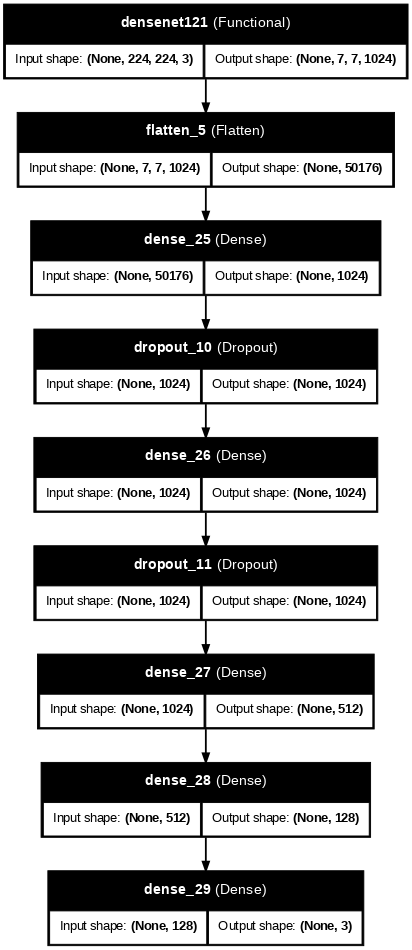

In [76]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image as IPImage

model_visualization_path = "/content/cnn_architecture.png"
plot_model(model, to_file = model_visualization_path, show_shapes = True, show_layer_names = True, dpi = 65)

IPImage(filename=model_visualization_path)

In [77]:
# to save the model results
from tensorflow.keras.models import load_model
model = load_model('/content/best_model.h5')


## Create Checkpoints and Callbacks to Save the Best Performing Model

In [78]:
# Where the best model will be saved
checkpoint_path = "/content/best_model2.h5"

# Define the callbacks
callbacks = [
    ModelCheckpoint(
        filepath = checkpoint_path,
        save_best_only = True,
        monitor = 'val_accuracy',
        save_weights_only = False,
        verbose = 1
    ),
    EarlyStopping(
        monitor = 'val_accuracy',
        patience = 5,
        restore_best_weights = True,
        verbose = 1
    ),
    ReduceLROnPlateau(            # reducing the learn rate
        monitor = 'val_loss',
        factor = 0.5,             # how much multi lr by
        patience = 3,             # 3 epochs
        verbose = 1
    )
]

# 7. Compile the Model

In [79]:
from tensorflow.keras.optimizers import Adam
# Compile
model.compile(
    optimizer = Adam(learning_rate = 1e-4),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

# 8. Train the Model

In [80]:
history = model.fit(
    train_gen,
    steps_per_epoch = len(train_gen),
    epochs = 10,
    validation_data = val_gen,
    validation_steps = len(val_gen),
    callbacks = callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6014 - loss: 1.0750
Epoch 1: val_accuracy improved from -inf to 0.26716, saving model to /content/best_model2.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 334s 9s/step - accuracy: 0.6015 - loss: 1.0736 - val_accuracy: 0.2672 - val_loss: 66929.5234 - learning_rate: 1.0000e-04
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.6175 - loss: 0.7980
Epoch 2: val_accuracy did not improve from 0.26716
21/21 ━━━━━━━━━━━━━━━━━━━━ 64s 848ms/step - accuracy: 0.6192 - loss: 0.7977 - val_accuracy: 0.2672 - val_loss: 4030.5828 - learning_rate: 1.0000e-04
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.6495 - loss: 0.7784
Epoch 3: val_accuracy improved from 0.26716 to 0.28358, saving model to /content/best_model2.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 143s 7s/step - accuracy: 0.6511 - loss: 0.7748 - val_accuracy: 0.2836 - val_loss: 270.1808 - learning_rate: 1.0000e-04
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.6687 - loss: 0.7239
Epoch 4: val_accuracy improved from 0.28358 to 0.44478, saving model to /content/best_model2.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 151s 7s/step - accuracy: 0.6689 - loss: 0.7284 - val_accuracy: 0.4448 - val_loss: 14.3120 - learning_rate: 1.0000e-04
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - accuracy: 0.7493 - loss: 0.5742
Epoch 5: val_accuracy improved from 0.44478 to 0.69552, saving model to /content/best_model2.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 149s 7s/step - accuracy: 0.7481 - loss: 0.5794 - val_accuracy: 0.6955 - val_loss: 1.3495 - learning_rate: 1.0000e-04
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 630ms/step - accuracy: 0.7575 - loss: 0.6054
Epoch 6: val_accuracy improved from 0.69552 to 0.80000, saving model to /content/best_model2.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 155s 8s/step - accuracy: 0.7565 - loss: 0.6053 - val_accuracy: 0.8000 - val_loss: 0.5200 - learning_rate: 1.0000e-04
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.7744 - loss: 0.5472
Epoch 7: val_accuracy did not improve from 0.80000
21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 889ms/step - accuracy: 0.7740 - loss: 0.5471 - val_accuracy: 0.8000 - val_loss: 0.5244 - learning_rate: 1.0000e-04
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.8016 - loss: 0.4620
Epoch 8: val_accuracy did not improve from 0.80000
21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 762ms/step - accuracy: 0.8021 - loss: 0.4608 - val_accuracy: 0.7970 - val_loss: 0.4506 - learning_rate: 1.0000e-04
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.8513 - loss: 0.3599
Epoch 9: val_accuracy improved from 0.80000 to 0.80448, saving model to /content/best_model2.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 160s 8s/step - accuracy: 0.8515 - loss: 0.3600 - val_accuracy: 0.8045 - val_loss: 0.4557 - learning_rate: 1.0000e-04
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.8921 - loss: 0.2715
Epoch 10: val_accuracy improved from 0.80448 to 0.87015, saving model to /content/best_model2.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 180s 9s/step - accuracy: 0.8920 - loss: 0.2726 - val_accuracy: 0.8701 - val_loss: 0.3601 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 10.


## Show the Training Results

In [82]:
# Creat a pandas dataframe to contain training hhistory metrics of the model
train_history = pd.DataFrame(history.history)

# Add new column for epoch number
train_history['Epoch'] = range(1, len(train_history) + 1)

# Order columns
train_history = train_history[['Epoch', 'loss', 'accuracy', 'val_loss', 'val_accuracy']]

train_history

,Epoch,loss,accuracy,val_loss,val_accuracy
0,1,1.043686,0.605067,66929.523438,0.267164
1,2,0.790842,0.655738,4030.582764,0.267164
2,3,0.699589,0.684054,270.180817,0.283582
3,4,0.822877,0.673621,14.311997,0.444776
4,5,0.690139,0.722802,1.349482,0.695522
5,6,0.603632,0.734724,0.520048,0.800000
6,7,0.545928,0.764531,0.524430,0.800000
7,8,0.437059,0.810730,0.450568,0.797015
8,9,0.362046,0.855440,0.455695,0.804478
9,10,0.295482,0.888227,0.360103,0.870149


## Plot the Training Validation Results

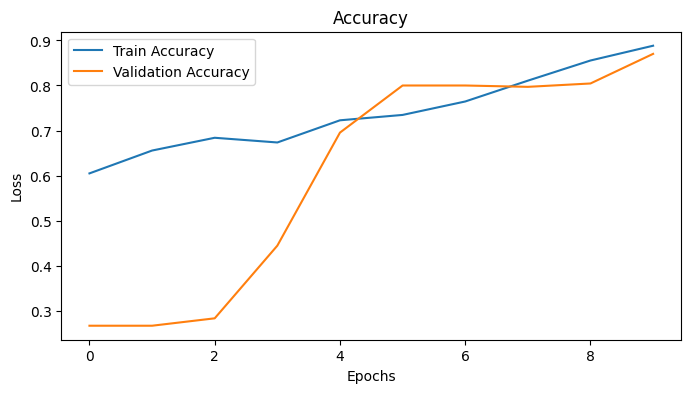

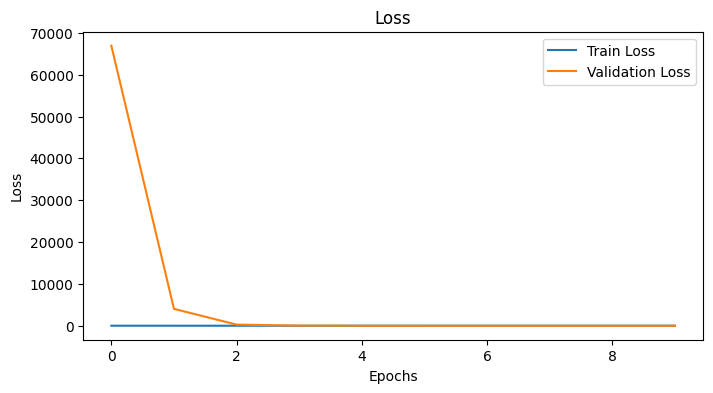

In [87]:
plt.figure(figsize = (8,4))
plt.plot(history.history['accuracy'], label = 'Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Accuracy')
plt.show()


plt.figure(figsize = (8,4))
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.show()

# 9. Evaluate the Modle

In [88]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8710 - loss: 0.3432
Test Accuracy: 0.8776, Test Loss: 0.3595


In [89]:
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

# create pandas dataframe with all 3
evaluation_results = pd.DataFrame({
    'Set': ['Train', 'Validation', 'Test'],
    'Accuracy': [train_accuracy, val_accuracy, test_acc],
    'Loss': [train_loss, val_loss, test_loss]
    })

evaluation_results

,Set,Accuracy,Loss
0,Train,0.888227,0.295482
1,Validation,0.870149,0.360103
2,Test,0.877637,0.359457


## Confusion Matrix

8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step


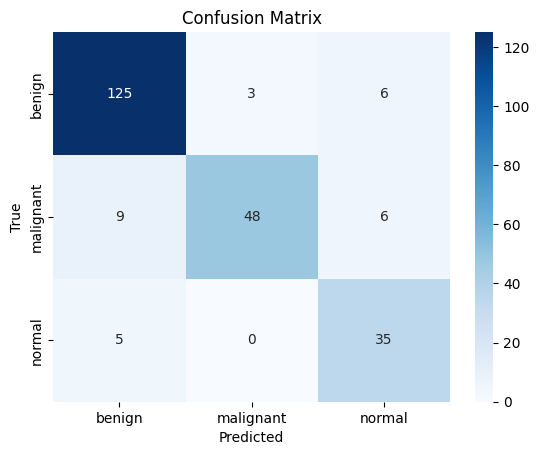

In [90]:
# 3 categories and predictions
y_true = test_df['Label'].values
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

# Class indices back to label names
class_names = list(test_gen.class_indices.keys())
y_true_idx = test_gen.classes

# Confusion Matrix
cm = confusion_matrix(y_true_idx, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Classification Report

In [91]:
y_true = test_gen.classes
y_pred = np.argmax(model.predict(test_gen), axis=1)
target_names = list(test_gen.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=target_names))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
              precision    recall  f1-score   support

      benign       0.90      0.93      0.92       134
   malignant       0.94      0.76      0.84        63
      normal       0.74      0.88      0.80        40

    accuracy                           0.88       237
   macro avg       0.86      0.86      0.85       237
weighted avg       0.88      0.88      0.88       237



## AUC-ROC

In [93]:
# one-hot encoding labels
y_true_bin = label_binarize(y_true, classes=[0,1,2])
y_pred_prob = model.predict(test_gen)

roc_auc = roc_auc_score(y_true_bin, y_pred_prob, average='macro', multi_class='ovr')
print("Macro-Averaged AUC-ROC:", roc_auc)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step
Macro-Averaged AUC-ROC: 0.958857502579732


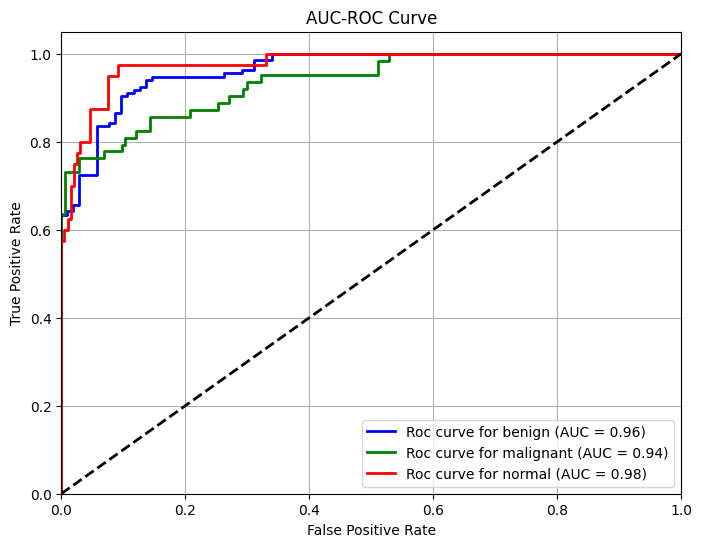

In [96]:
# plot AUC-ROC
fpr = {}
tpr = {}
roc_auc = {}

# Labels from test_gen
class_names = list(test_gen.class_indices.keys())
n_classes = len(class_names)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'red']

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'Roc curve for {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0,1], [0,1], 'k--', lw = 2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
